## EA TREX single-cell barcode tracing data

## Preprocessing script for Emilia iPSC barcode tracing data
### 4 samples across two batches and two time points(shared barcodes)

#### run under r4-crispr

load packages, directories and plot function

In [89]:
#load packages
suppressMessages({
    library(dplyr)
    library(data.table)
    library(ggplot2)
    library(ggrepel)
    library(UpSetR)
    library(pheatmap)
    library(grid)
    library(RColorBrewer)
    library(viridis)
    library(Seurat)
    library(scales)
    library(reshape2)
    library(stringr)
    library(magrittr)
    library(cowplot)
    library(hrbrthemes)
    library(GGally)
    library(scCustomize)
    library(patchwork)
})

In [90]:
#Caution, data alignment input path changed
dat_input<-".../Analysis_script/Alignment_BC/"
trex_input<-".../Analysis_script/TREX_output_diffDay/"
output_dir<-".../Analysis_script/Output/"

pdim<-function(x,y){
    return(options(repr.plot.width=x, repr.plot.height=y))
}

## first read in transcriptome alignment result and generate seurat object list

In [91]:
#define sample names
sample_names<-list.files(dat_input)
sample_ID<-c("scl1d17","scl2d17","scl1d28","scl2d28")
replicate_ID<-c("scl1","scl2","scl1","scl2")
diff_day<-c("d17","d17","d28","d28")

#first read in expression matrix
#prepare expression and object list
obj_list<-vector(mode = "list", length = 4)

#read data into list
for(i in 1:4){
    exp<-Read10X(paste0(dat_input, sample_names[[i]], 
                                  "/outs/filtered_feature_bc_matrix/"))
    obj<-CreateSeuratObject(exp)
    obj@meta.data$rep<-replicate_ID[[i]]
    obj@meta.data$diff_day<-diff_day[[i]]
    obj@meta.data$sample_ID<-sample_ID[[i]]
    obj@meta.data$seq_ID<-sample_names[[i]]
    
    obj_list[[i]]<-obj
    
    }

names(obj_list)<-sample_ID

obj_list

$scl1d17
An object of class Seurat 
38607 features across 3493 samples within 1 assay 
Active assay: RNA (38607 features, 0 variable features)

$scl2d17
An object of class Seurat 
38607 features across 5023 samples within 1 assay 
Active assay: RNA (38607 features, 0 variable features)

$scl1d28
An object of class Seurat 
38607 features across 2287 samples within 1 assay 
Active assay: RNA (38607 features, 0 variable features)

$scl2d28
An object of class Seurat 
38607 features across 3635 samples within 1 assay 
Active assay: RNA (38607 features, 0 variable features)


## read in clone ID information for each sample from TREX output folder

In [93]:
clones<-list.files(trex_input, full.names = TRUE)

clone_lists<-list()

clone_lists<-lapply(clones, FUN = function(x){
    tmp<-read.csv(file = paste0(x, "/clones.txt"), sep = "\t")
    return(tmp)
})

In [94]:
head(clone_lists[[1]])

,clone_nr,cell_id
,<int>,<chr>
1,1,scl1d17_CATGCAACAAAGCTAA
2,2,scl1d17_AACAACCTCCTTCACG
3,3,scl1d17_CAGTGCGCACCCTAAA
4,4,scl1d17_CGTGCTTCATTAAGCC
5,5,scl1d28_TCGAAGTGTCCATAGT
6,6,scl1d17_CTCGAGGTCAATCTCT


In [95]:
for(i in 1:2){
    clone_lists[[i]]$rep<-replicate_ID[[i]]
    clone_lists[[i]]$clone_nr<-paste0(replicate_ID[[i]],"_", clone_lists[[i]]$clone_nr)
    clone_lists[[i]]$diff_day<-NA
    
    for(k in 1:nrow(clone_lists[[i]])){
        clone_lists[[i]]$diff_day[[k]]<-gsub(replicate_ID[[i]], "",
                                             strsplit(clone_lists[[i]]$cell_id[[k]], "_")[[1]][1]
                                             )
    }
}

head(clone_lists[[1]])

,clone_nr,cell_id,rep,diff_day
,<chr>,<chr>,<chr>,<chr>
1,scl1_1,scl1d17_CATGCAACAAAGCTAA,scl1,d17
2,scl1_2,scl1d17_AACAACCTCCTTCACG,scl1,d17
3,scl1_3,scl1d17_CAGTGCGCACCCTAAA,scl1,d17
4,scl1_4,scl1d17_CGTGCTTCATTAAGCC,scl1,d17
5,scl1_5,scl1d28_TCGAAGTGTCCATAGT,scl1,d28
6,scl1_6,scl1d17_CTCGAGGTCAATCTCT,scl1,d17


In [96]:
dim(clone_lists[[1]])
dim(clone_lists[[2]])

clone_merge<-rbind(clone_lists[[1]], clone_lists[[2]])
dim(clone_merge)

[1] 4431    4

[1] 6233    4

[1] 10664     4

## Merge all samples and align clone ID from new TREX calculation
make sure all clone IDs are combined with sample ID
afterwards, merge clone ID into object meta.data

In [98]:
#merge all objs
obj<-Merge_Seurat_List(obj_list, add.cell.ids = sample_ID)

#prepare cell cycle scoring
(Sgenes <- cc.genes$s.genes)
(G2Mgenes <- cc.genes$g2m.genes)

obj <- CellCycleScoring(obj, s.features = Sgenes, 
                        g2m.features = G2Mgenes, set.ident = TRUE)

[1] "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    
 [7] "RRM1"     "UNG"      "GINS2"    "MCM6"     "CDCA7"    "DTL"     
[13] "PRIM1"    "UHRF1"    "MLF1IP"   "HELLS"    "RFC2"     "RPA2"    
[19] "NASP"     "RAD51AP1" "GMNN"     "WDR76"    "SLBP"     "CCNE2"   
[25] "UBR7"     "POLD3"    "MSH2"     "ATAD2"    "RAD51"    "RRM2"    
[31] "CDC45"    "CDC6"     "EXO1"     "TIPIN"    "DSCC1"    "BLM"     
[37] "CASP8AP2" "USP1"     "CLSPN"    "POLA1"    "CHAF1B"   "BRIP1"   
[43] "E2F8"

[1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”


In [99]:
head(obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,rep,diff_day,sample_ID,seq_ID,S.Score,G2M.Score,Phase,old.ident
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
scl1d17_AAACCCACATCTCCCA-1,SeuratProject,32025,7114,scl1,d17,scl1d17,P33352_1001,2.11131167,-1.6152878,S,SeuratProject
scl1d17_AAACCCACATTCTCTA-1,SeuratProject,23554,6372,scl1,d17,scl1d17,P33352_1001,0.02114492,5.2337308,G2M,SeuratProject
scl1d17_AAACCCAGTAAGTAGT-1,SeuratProject,45823,8474,scl1,d17,scl1d17,P33352_1001,-2.31751762,-3.9524215,G1,SeuratProject
scl1d17_AAACCCAGTACTCCCT-1,SeuratProject,15669,5198,scl1,d17,scl1d17,P33352_1001,-1.08664260,-1.4872634,G1,SeuratProject
scl1d17_AAACCCAGTTTCGGCG-1,SeuratProject,12812,4474,scl1,d17,scl1d17,P33352_1001,0.16013409,3.8461151,G2M,SeuratProject
scl1d17_AAACCCATCATGGATC-1,SeuratProject,24608,6534,scl1,d17,scl1d17,P33352_1001,1.52303593,0.1896558,S,SeuratProject


In [100]:
obj@meta.data$Clone_ID<-NA
obj@meta.data$Barcode<-NA

    for(i in 1:nrow(obj@meta.data)){
        cell<-strsplit(rownames(obj@meta.data)[i],"-")[[1]][1]
        position<-match(paste0(cell), 
                        clone_merge$cell_id)
        if (is.na(position) == TRUE){
            obj@meta.data$Barcode[[i]]<-"Neg"
            obj@meta.data$Clone_ID[[i]]<-"Neg"
        }else{
            obj@meta.data$Barcode[[i]]<-"Pos"
            obj@meta.data$Clone_ID[[i]]<-clone_merge$clone_nr[position]
        }
    }

print(table(obj@meta.data$Barcode, obj@meta.data$rep))
print(length(unique(obj@meta.data$Clone_ID)))

     
      scl1 scl2
  Neg 1349 2425
  Pos 4431 6233
[1] 9537


## proceed with transcriptome analysis

Centering and scaling data matrix

PC_ 1 
Positive:  VIM, HMGB2, IGFBP2, HMGA2, COL4A5, CCND2, CKS1B, TYMS, B2M, ZFP36L1 
	   SPARC, LINC01515, SMC4, DUSP6, CENPF, S100A11, FBN2, MAD2L1, PCLAF, H2AZ1 
	   CKS2, CALD1, PRTG, GNG11, BIRC5, TOP2A, PTN, CENPK, GPC3, PTTG1 
Negative:  STMN2, DCX, NRXN1, GAP43, KIF5C, ONECUT2, RTN1, INA, ELAVL4, AKAP6 
	   NCAM1, ELAVL3, STMN4, SCN3A, MAPT, CCSER1, MAP1B, PAK3, XKR4, ANK3 
	   SYT1, NSG2, NAV3, CRMP1, ATP1A3, ONECUT3, TSPAN7, MYT1L, GNG3, NSG1 
PC_ 2 
Positive:  UBE2S, KPNA2, TUBB4B, UBE2C, H2AZ1, ARL6IP1, CCNB1, TPX2, TUBA1A, NUSAP1 
	   DLGAP5, TOP2A, CDCA8, CDC20, TTK, GTSE1, ASPM, CDK1, DEPDC1, CDCA3 
	   CCNA2, H2AX, CDKN3, SGO2, CENPA, HMMR, AURKB, PLK1, TUBB2A, TUBB2B 
Negative:  PLEKHA5, SLIT2, RMST, MAGI2, SLC44A5, ZBTB20, CTNNA3, NEAT1, ATXN1, ADGRV1 
	   LINC02315, ENSG00000258631, FREM1, ENSG00000225689, SOX5, TTC6, SULF1, NPAS3, PLXDC2, TENM3 
	   MAML3, PRKG1, IL1RAPL1, ENSG00000257060, PLCL1, RORA, SOX6, KCNQ1OT1, ADAMTS6, CNT

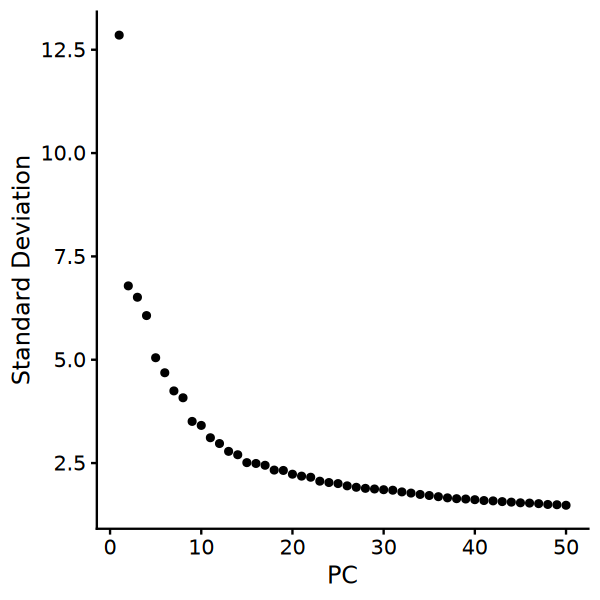

In [101]:
obj<-subset(obj, subset = nFeature_RNA >500) %>%
    NormalizeData(.) %>%
    ScaleData(., features = rownames(obj)) %>%
    FindVariableFeatures(.) %>%
    RunPCA(.)

ElbowPlot(obj, ndims = 50)

In [102]:
obj<-RunUMAP(obj, dims = 1:30, verbose = F) %>%
    FindNeighbors(., reduction = "pca", assay = "RNA", dims = 1:30) %>%
    FindClusters(., resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14147
Number of edges: 461876

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9205
Number of communities: 16
Elapsed time: 1 seconds


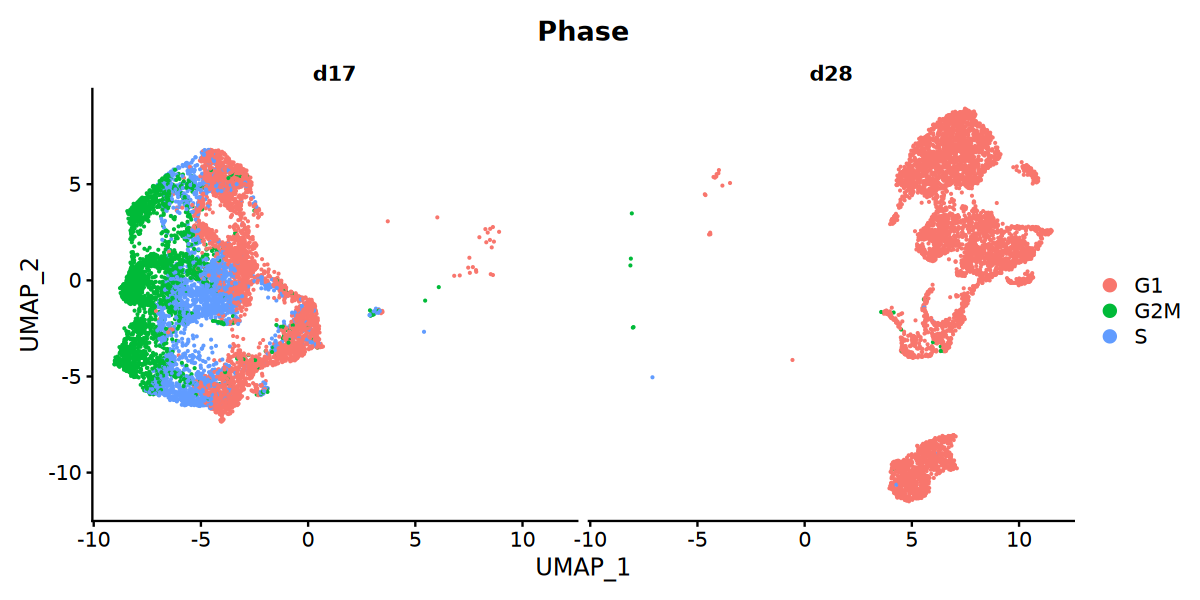

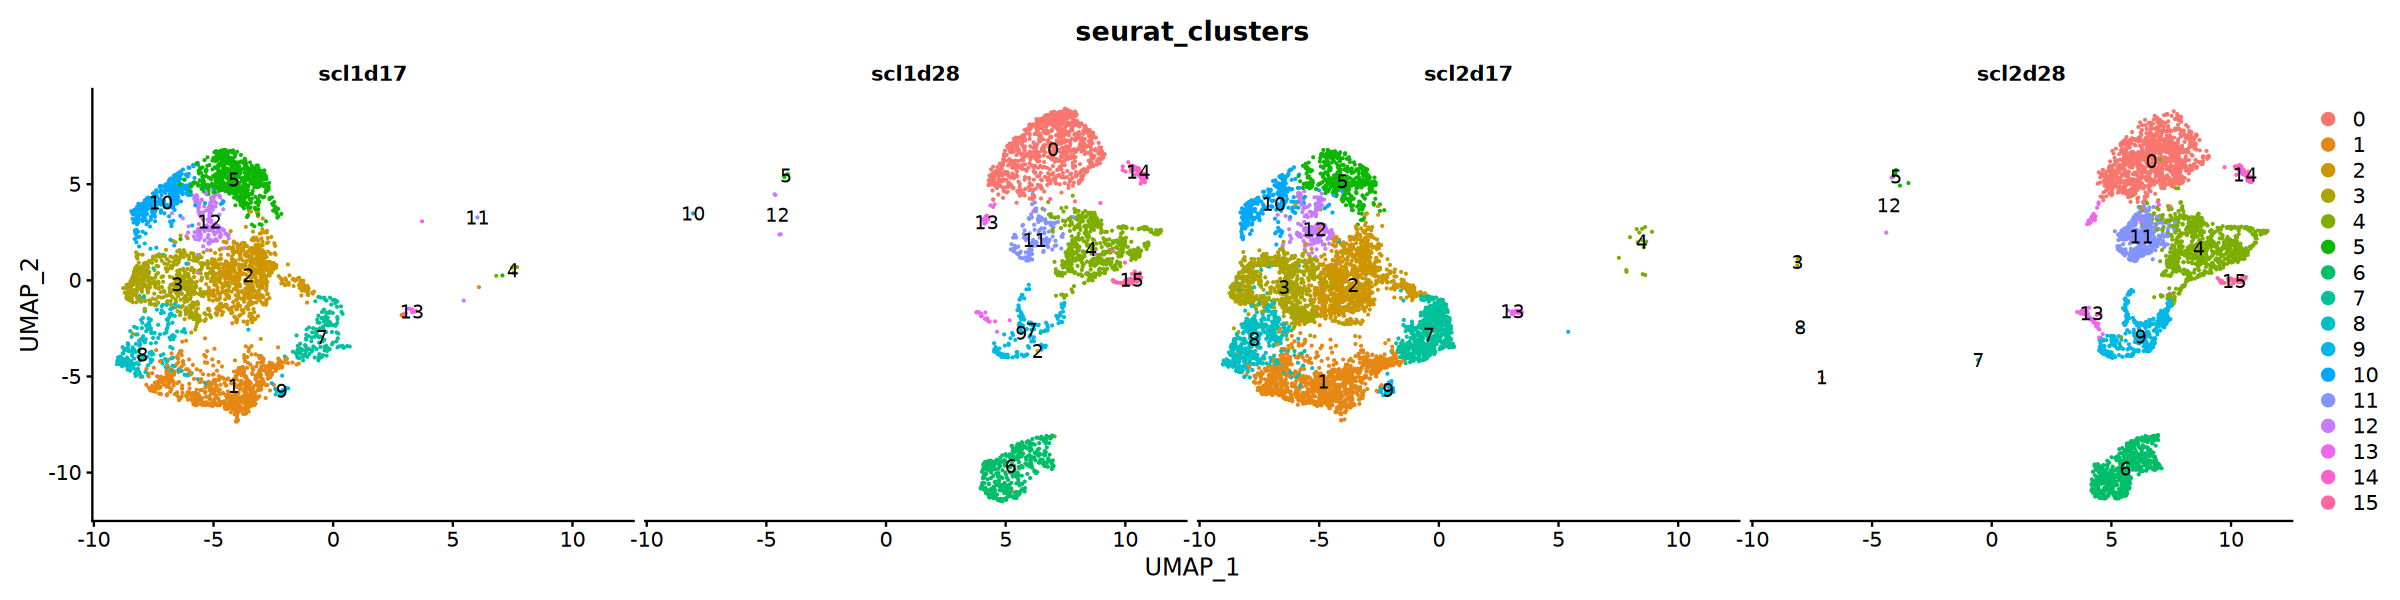

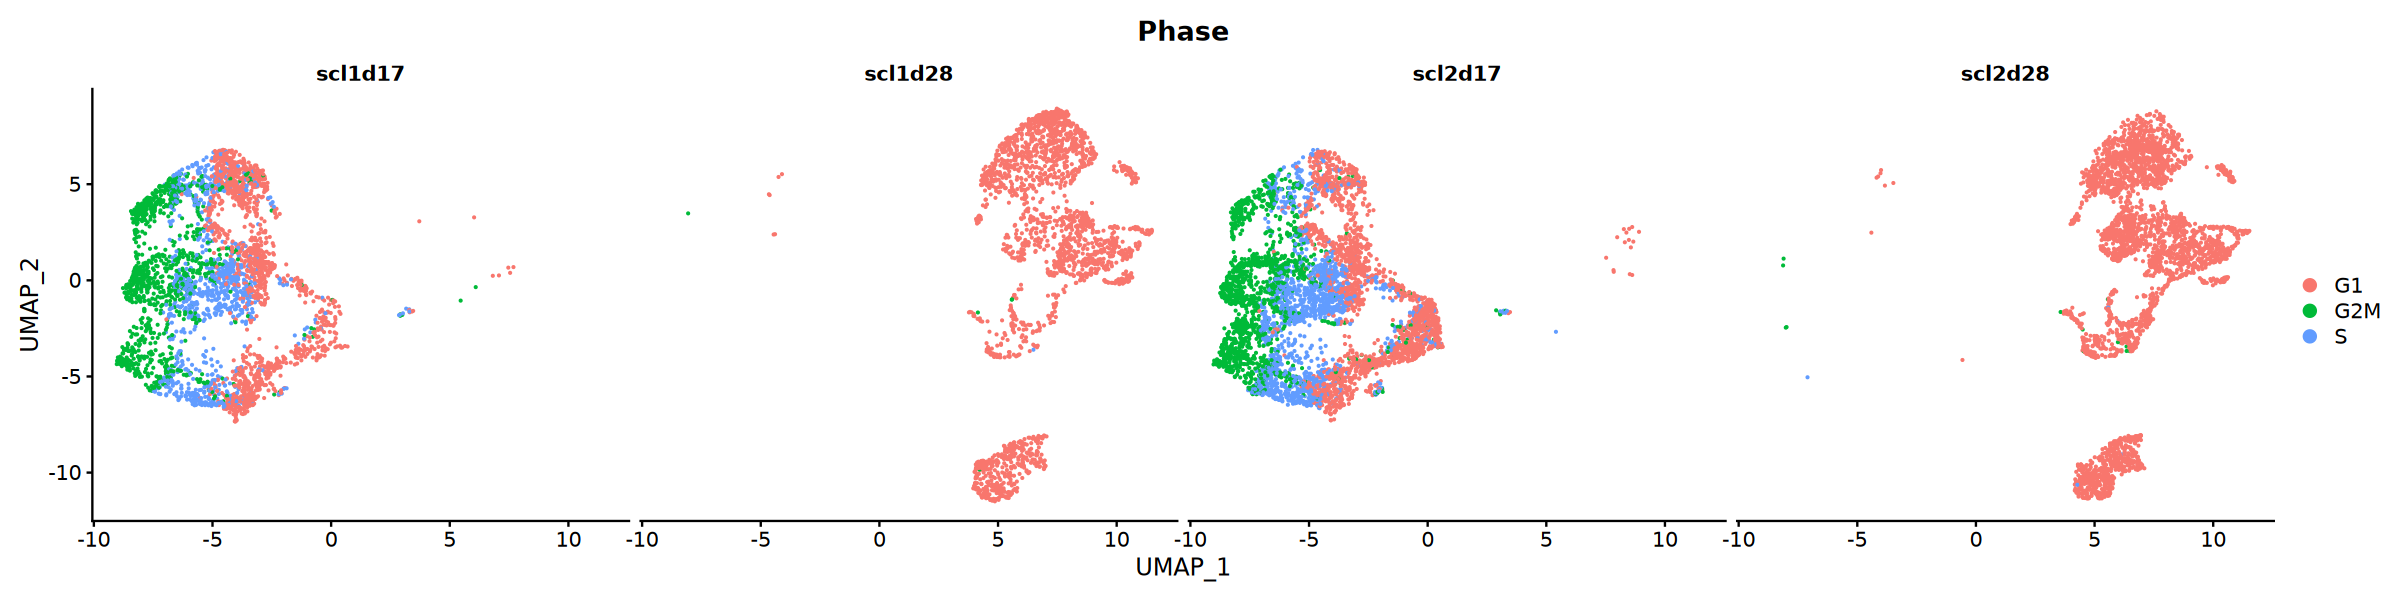

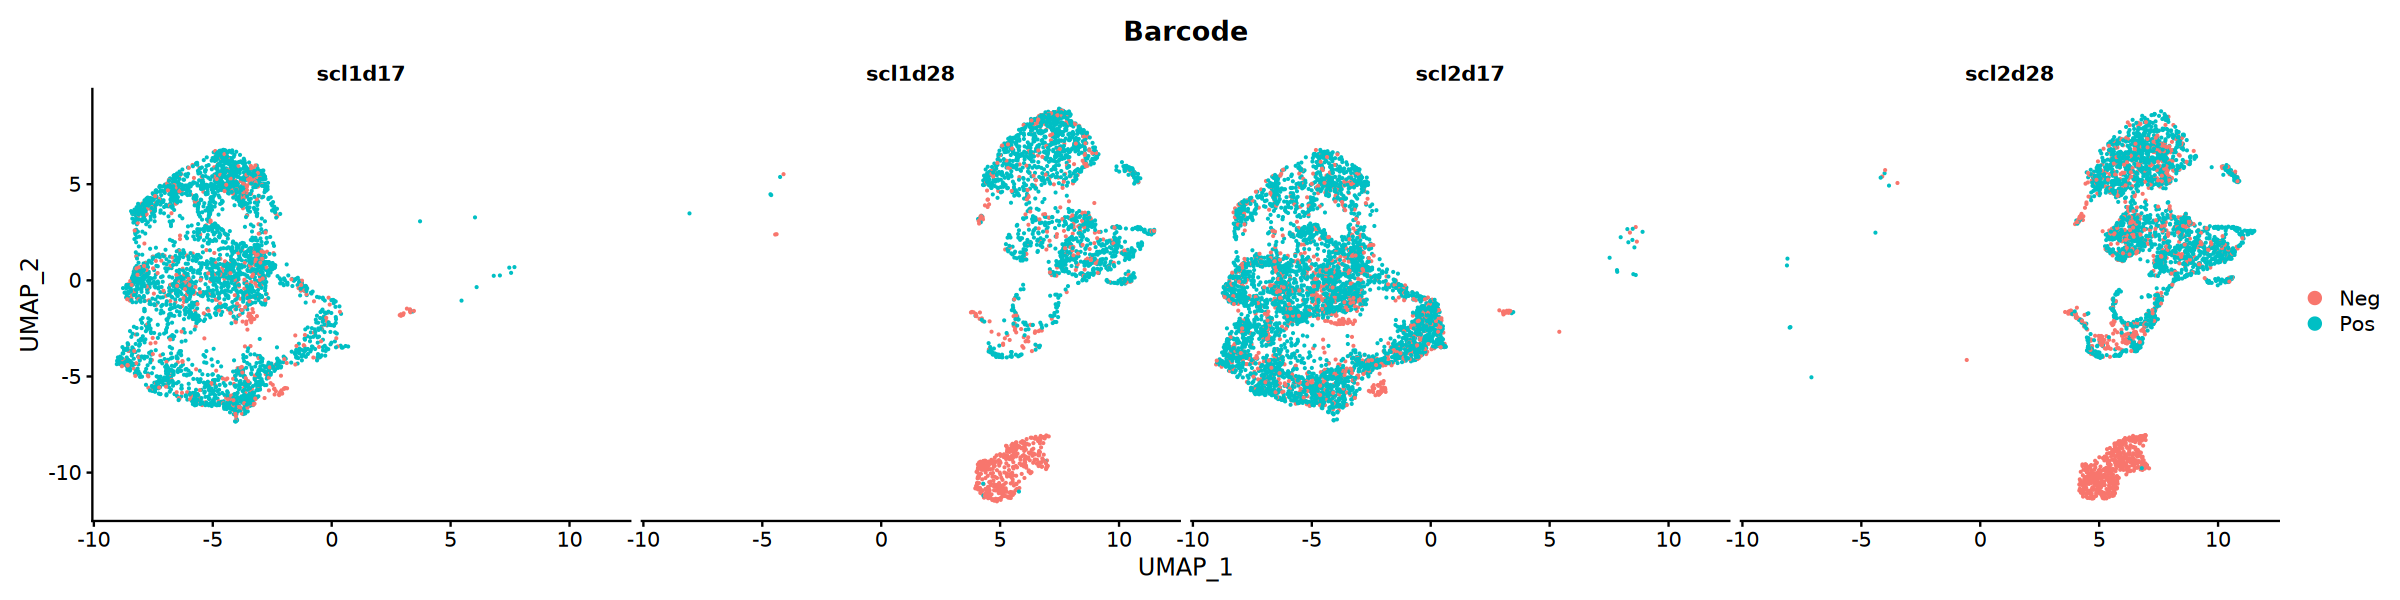

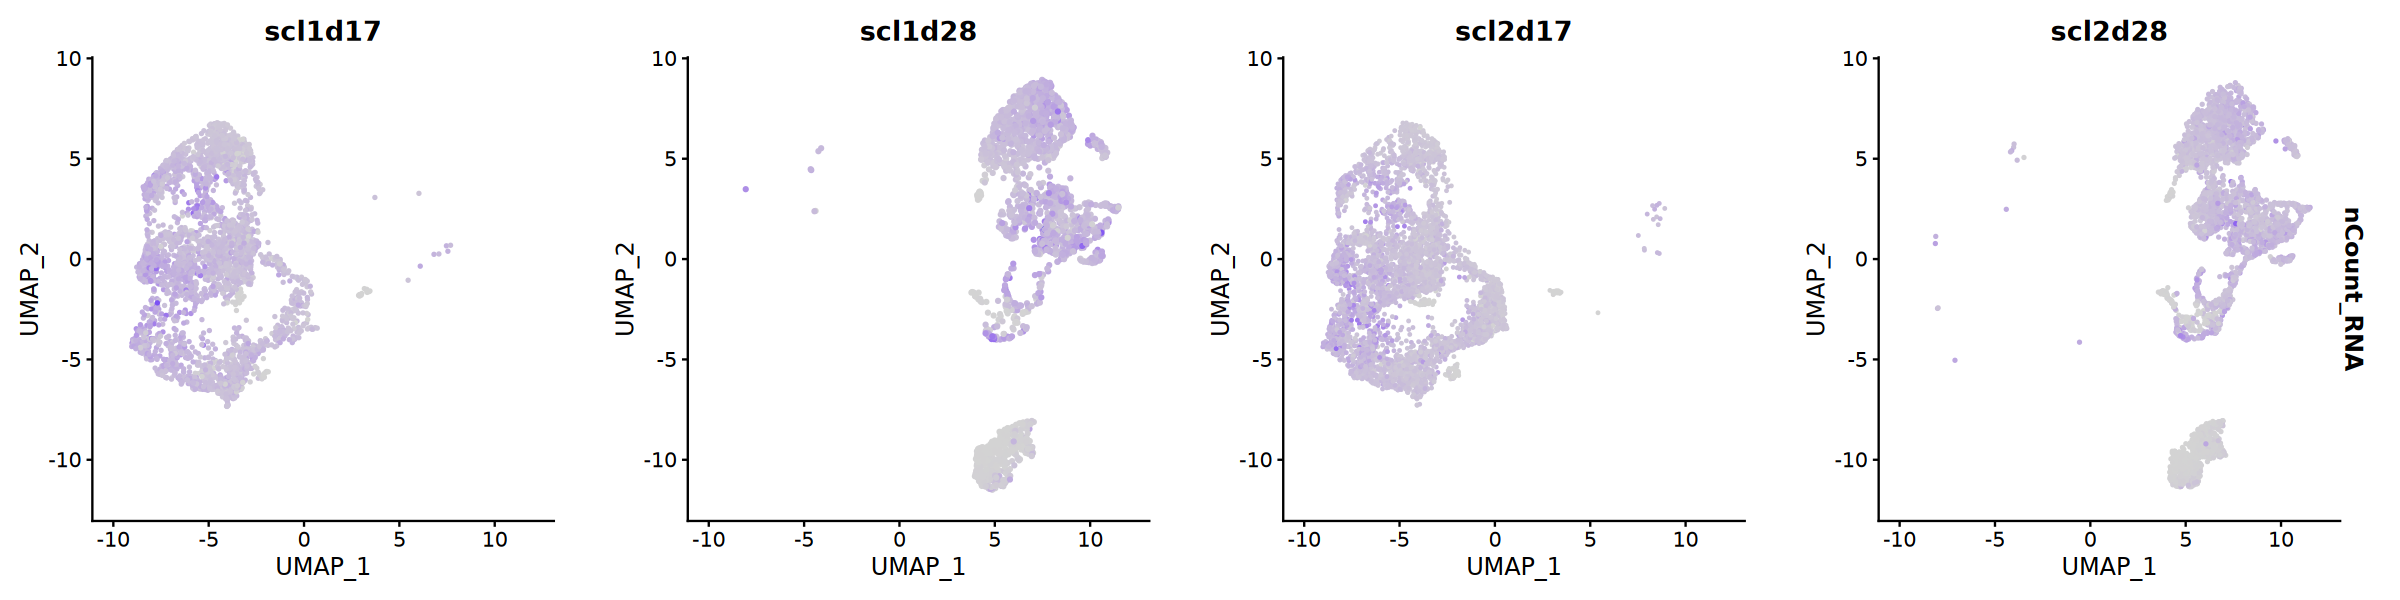

In [103]:
pdim(10,5)
DimPlot(obj, group.by = "Phase", split.by = "diff_day")

pdim(20,5)
DimPlot(obj, group.by = "seurat_clusters", split.by = "sample_ID", label = TRUE)
DimPlot(obj, group.by = "Phase", split.by = "sample_ID")
DimPlot(obj, group.by = "Barcode", split.by = "sample_ID")

FeaturePlot(obj, feature = "nCount_RNA", split.by = "sample_ID")

## brief check of clone ID distributions

across batch and time points, respectively

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


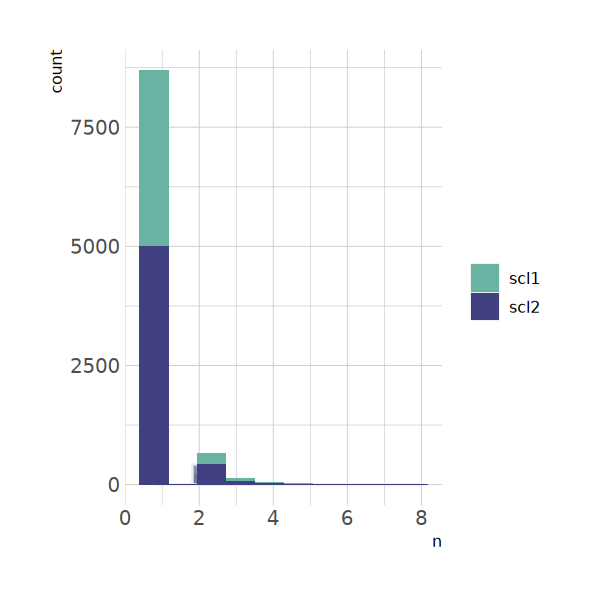

In [114]:
clone_count<-clone_merge %>% group_by(rep) %>% count(clone_nr)

#histogram visualisation by seperating two replicates
p <- clone_count %>%
  ggplot( aes(x=n, fill=rep )) +
    geom_histogram( color="#e9ecef", alpha=0.6, position = 'identity') +
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    stat_bin(bins = 10)+
    theme_ipsum() +
    labs(fill="")

pdim(5,5)
p

In [116]:
head(clone_count)

rep,clone_nr,n
<chr>,<chr>,<int>
scl1,scl1_1,1
scl1,scl1_10,1
scl1,scl1_100,1
scl1,scl1_1000,3
scl1,scl1_1001,1
scl1,scl1_1002,1


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


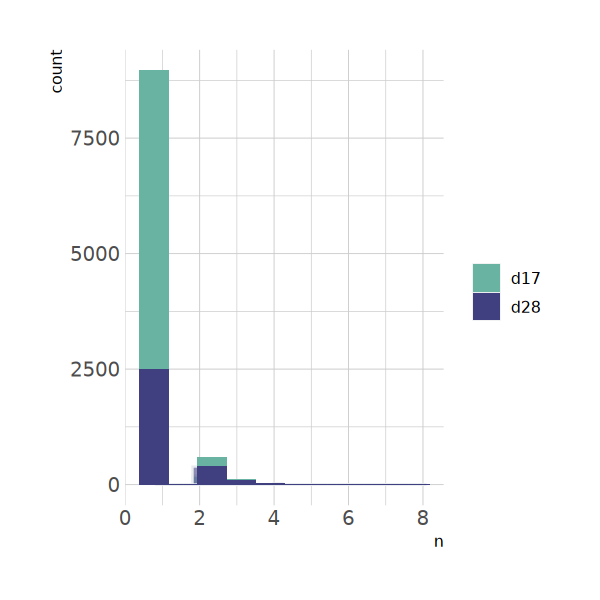

In [112]:
clone_count<-clone_merge %>% group_by(diff_day) %>% count(clone_nr)

#histogram visualisation by seperating two time points
p <- clone_count %>%
  ggplot( aes(x=n, fill=diff_day )) +
    geom_histogram( color="#e9ecef", alpha=0.6, position = 'identity') +
    scale_fill_manual(values=c("#69b3a2", "#404080")) +
    stat_bin(bins = 10)+
    theme_ipsum() +
    labs(fill="")

pdim(5,5)
p

## proceed with unbiased cluster marker calculation and visualisation

In [21]:
# Find markers and limit to those expressed in greater than 75% of target population
Idents(obj)<-"seurat_clusters"

cluster_markers <- FindAllMarkers(object = obj, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



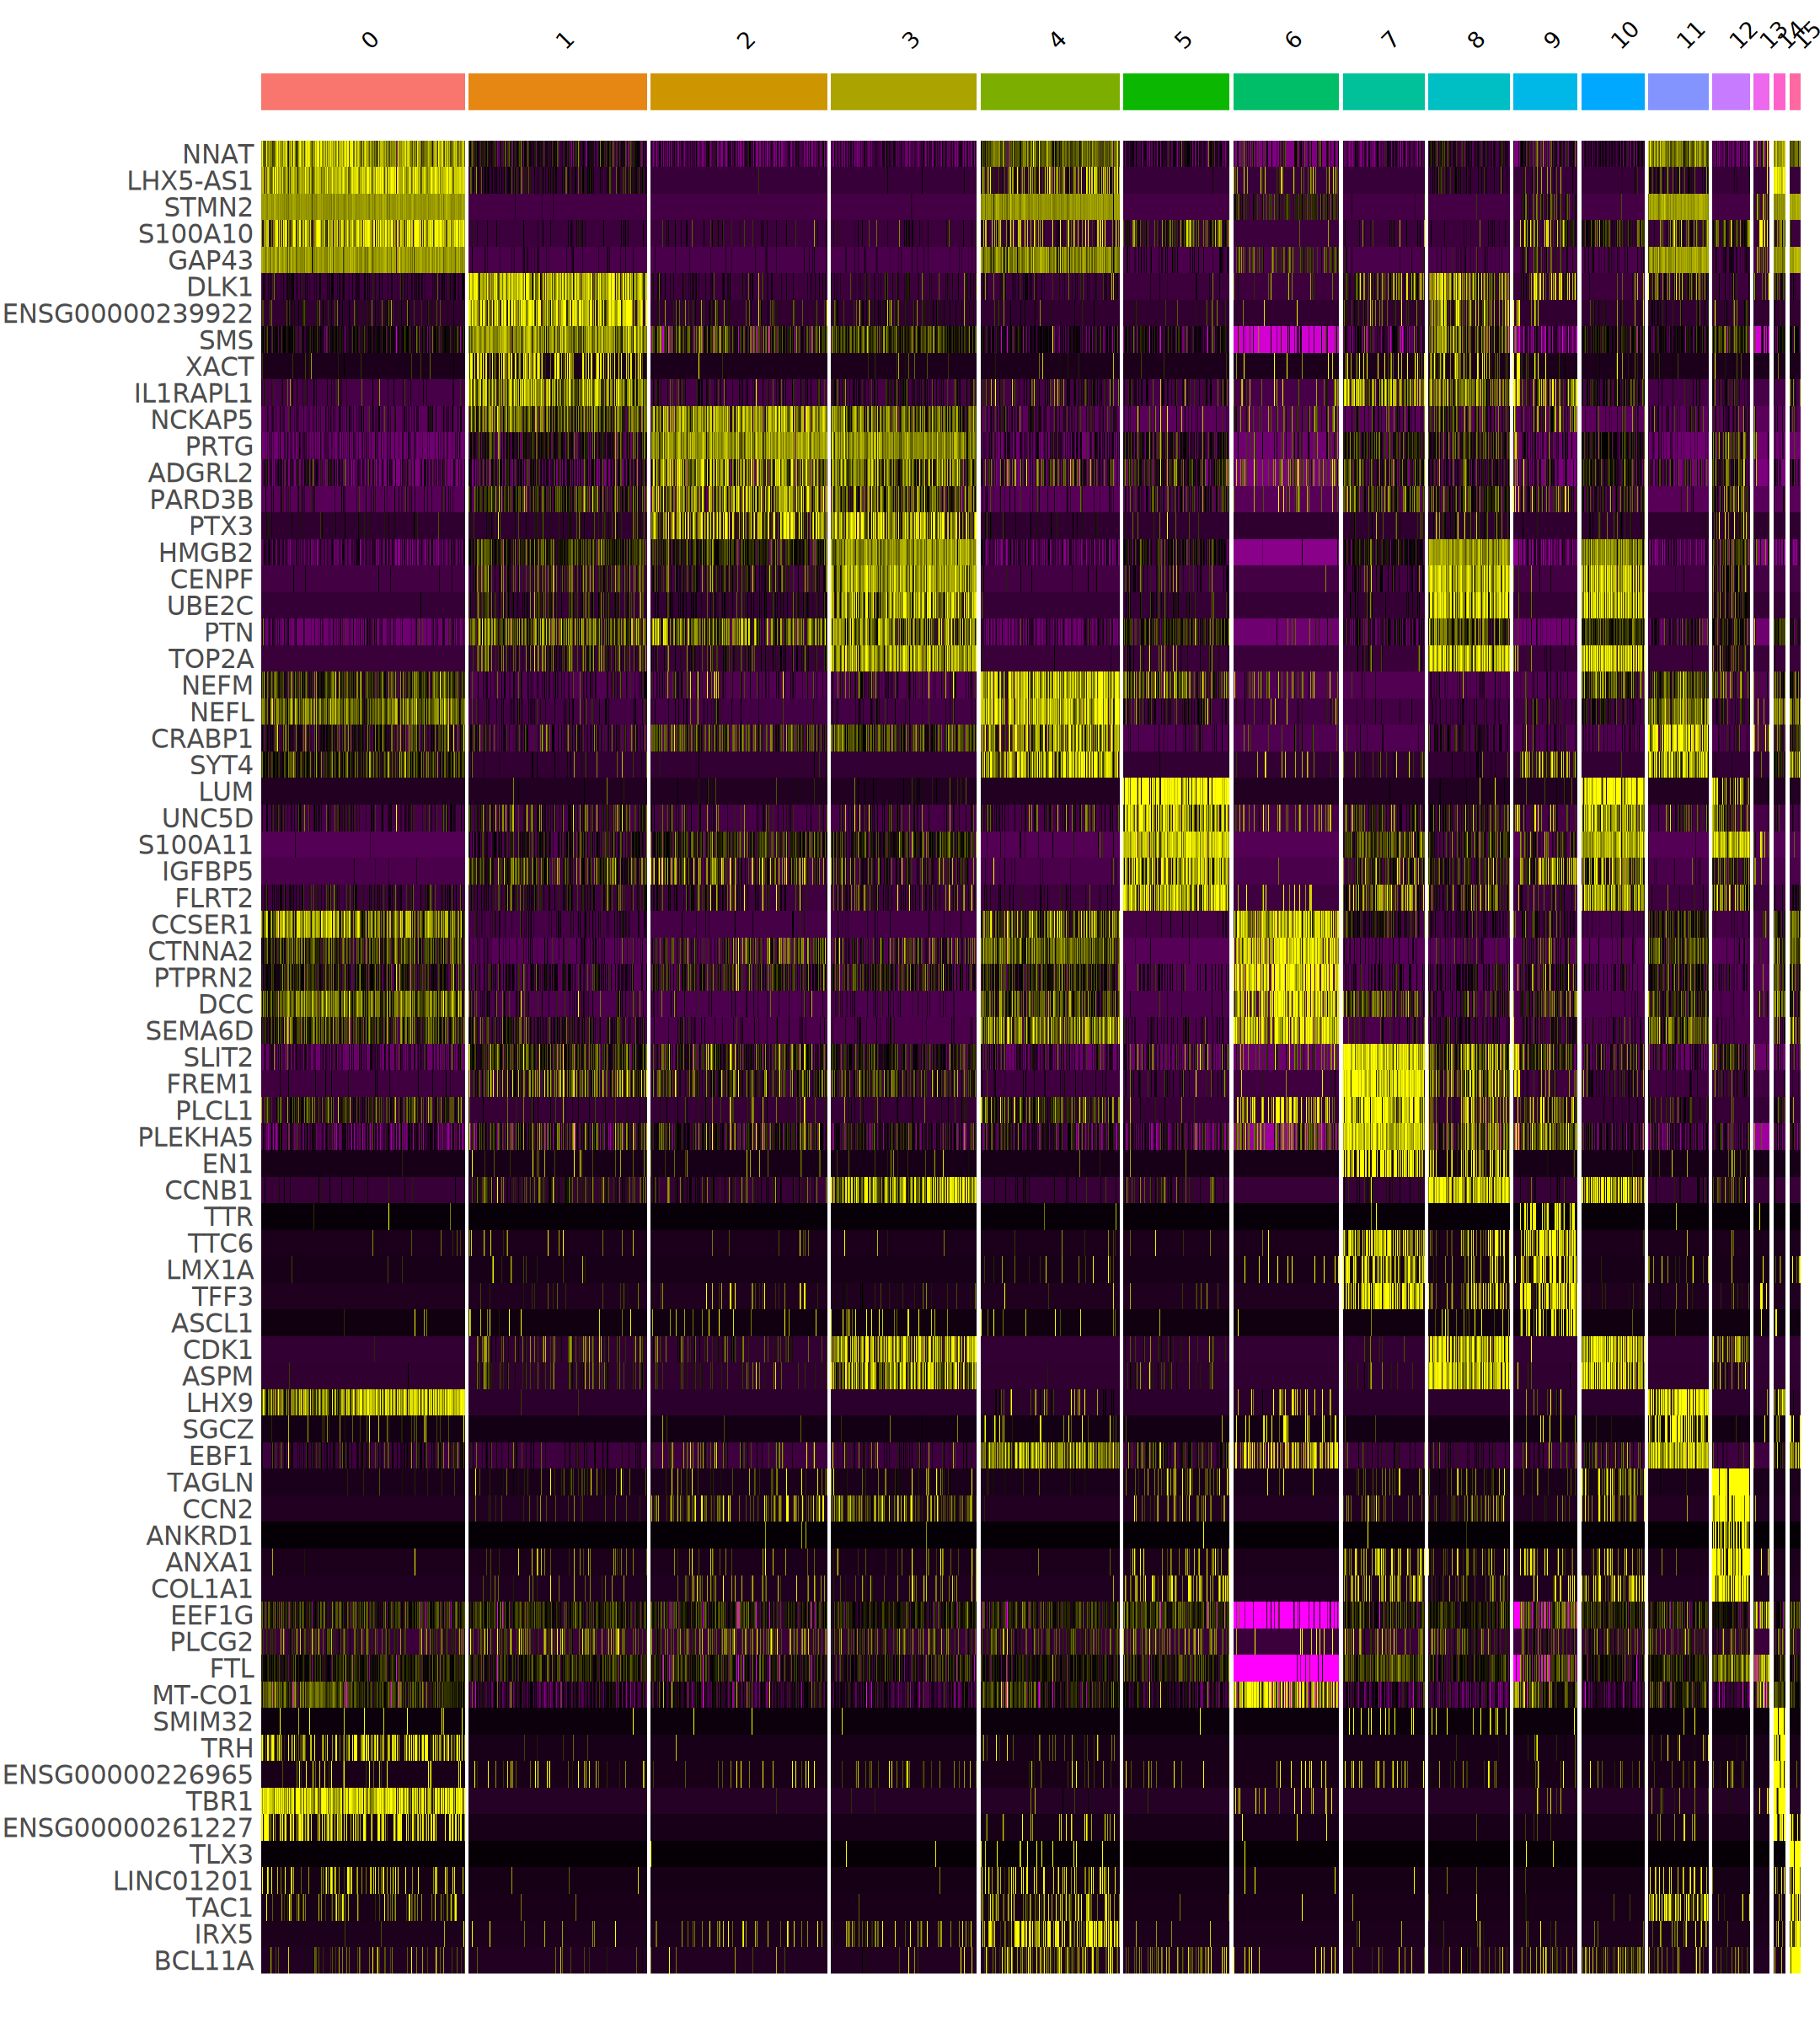

In [22]:
#seurat heatmap representation
cluster_markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 5) %>%
    ungroup() -> top5

pdim(18,20)
DoHeatmap(obj, features = top5$gene) + NoLegend() + theme(axis.text.y = element_text(size = 18))

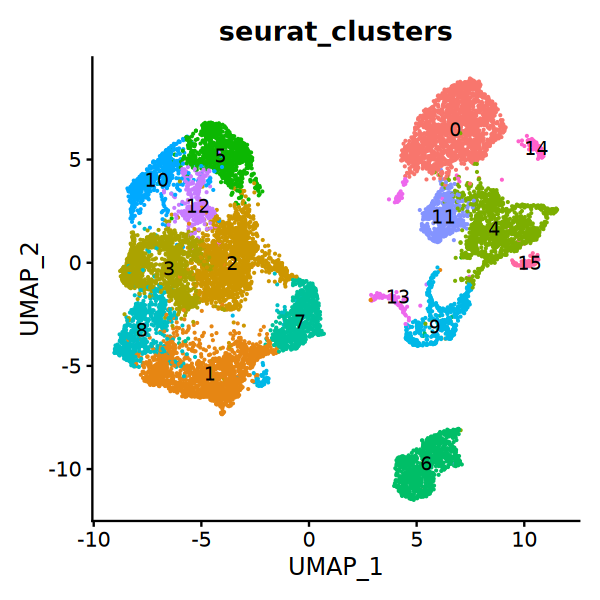

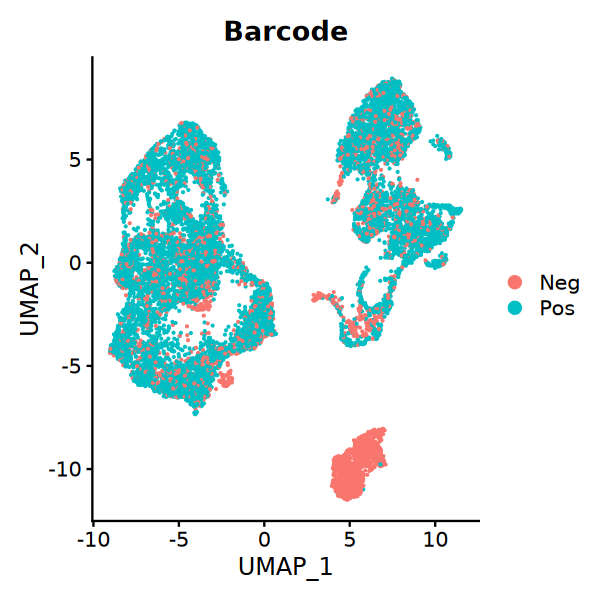

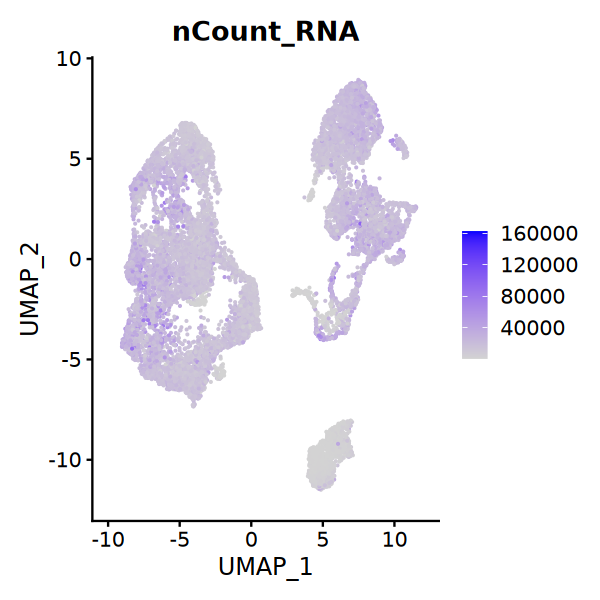

In [23]:
pdim(5,5)
DimPlot(obj, group.by = "seurat_clusters", label = TRUE) +NoLegend()
DimPlot(obj, group.by = "Barcode")
FeaturePlot(obj, features = "nCount_RNA")

### hunt for clone IDs that are shared by both time points and plot

In [79]:
obj_meta<-obj@meta.data

head(obj_meta)

,orig.ident,nCount_RNA,nFeature_RNA,rep,diff_day,sample_ID,seq_ID,S.Score,G2M.Score,Phase,old.ident,Clone_ID,Barcode,RNA_snn_res.0.5,seurat_clusters
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>,<fct>,<fct>
scl1d17_AAACCCACATCTCCCA-1,SeuratProject,32025,7114,scl1,d17,scl1d17,P33352_1001,2.11131167,-1.6152878,S,SeuratProject,scl1_1967,Pos,12,12
scl1d17_AAACCCACATTCTCTA-1,SeuratProject,23554,6372,scl1,d17,scl1d17,P33352_1001,0.02114492,5.2337308,G2M,SeuratProject,scl1_3859,Pos,3,3
scl1d17_AAACCCAGTAAGTAGT-1,SeuratProject,45823,8474,scl1,d17,scl1d17,P33352_1001,-2.31751762,-3.9524215,G1,SeuratProject,scl1_3542,Pos,2,2
scl1d17_AAACCCAGTACTCCCT-1,SeuratProject,15669,5198,scl1,d17,scl1d17,P33352_1001,-1.08664260,-1.4872634,G1,SeuratProject,scl1_3330,Pos,1,1
scl1d17_AAACCCAGTTTCGGCG-1,SeuratProject,12812,4474,scl1,d17,scl1d17,P33352_1001,0.16013409,3.8461151,G2M,SeuratProject,scl1_2423,Pos,3,3
scl1d17_AAACCCATCATGGATC-1,SeuratProject,24608,6534,scl1,d17,scl1d17,P33352_1001,1.52303593,0.1896558,S,SeuratProject,scl1_656,Pos,10,10


In [68]:
#use which condition to filter out IDs that are traceble across two time points
clone_multi<-vector()
clone_nr<-unique(obj_meta$Clone_ID)

for(i in 1:9529){
    positions<-grep(clone_nr[[i]], obj_meta$Clone_ID)
    diff_d<-unique(obj_meta$diff_day[positions])
    
    if(length(diff_d)>=2){
        clone_multi<-append(clone_multi, values = clone_nr[[i]])
    }else{
        clone_multi<-clone_multi
    } 
}

In [80]:
length(clone_multi)

[1] 1098

In [81]:
head(clone_multi)

[1] "Neg"       "scl1_235"  "scl1_389"  "scl1_398"  "scl1_1150" "scl1_2"

In [82]:
clone_all_3plus<-clone_count %>% filter(n>=3)

In [83]:
head(clone_all_3plus)

diff_day,clone_nr,n
<chr>,<chr>,<int>
d17,scl1_1449,3
d17,scl1_1817,3
d17,scl1_876,3
d17,scl2_1376,3
d17,scl2_2714,3
d17,scl2_5137,3


In [77]:
intersect(clone_multi, clone_all_3plus$clone_nr)

#in total 16 IDs


[1] "scl1_2750" "scl1_2102" "scl2_5322" "scl2_4548" "scl2_1991" "scl2_3129"
 [7] "scl2_2006" "scl2_4037" "scl2_4337" "scl2_2827" "scl2_2198" "scl1_108" 
[13] "scl1_400"  "scl2_516"  "scl2_523"  "scl2_231"

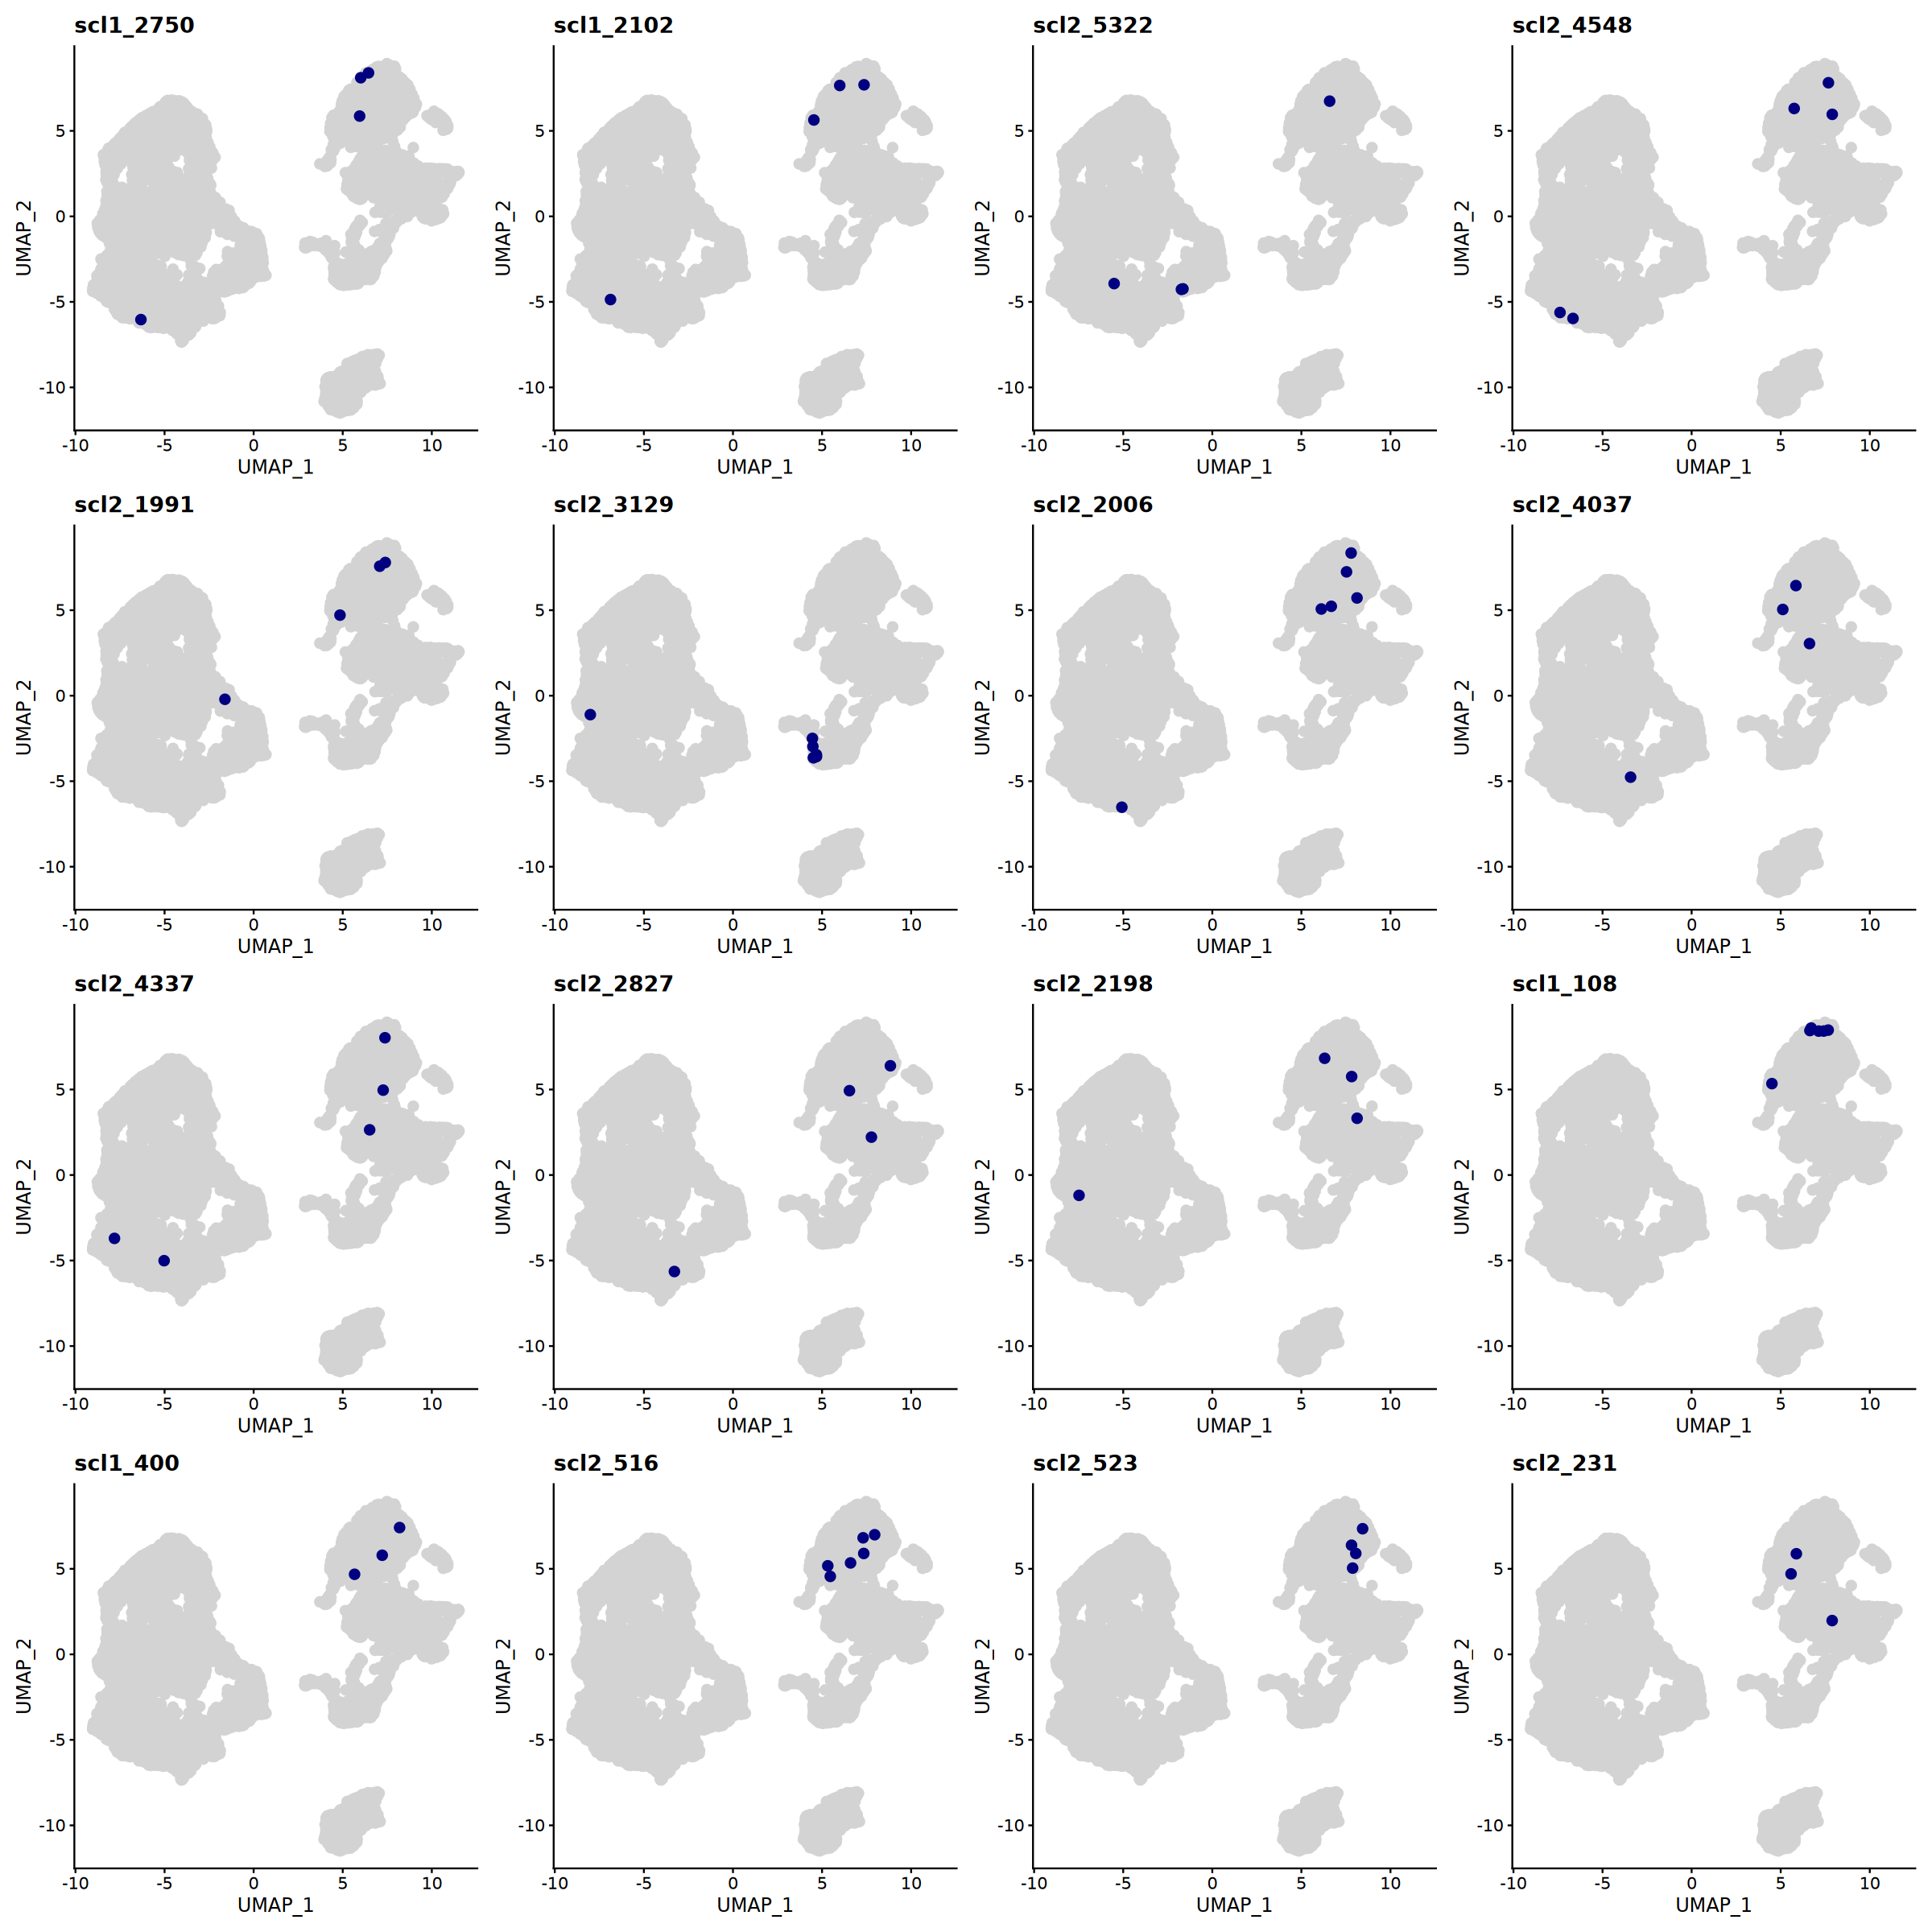

In [87]:
# Get cell names and make list
umap.list<-list()
Idents(obj)<-"Clone_ID"
                            

for(i in 1:16){
    # Plot
    umap.list[[i]]<- Meta_Highlight_Plot(seurat_object = obj, 
                                         pt.size = 3,
                                         meta_data_column = "Clone_ID",
                                         meta_data_highlight = intersect(clone_multi, clone_all_3plus$clone_nr)[[i]], 
                                         highlight_color = "navy", background_color = "lightgray")+
                        NoLegend()+
                        ggtitle(intersect(clone_multi, clone_all_3plus$clone_nr)[[i]])
}

pdim(20,20)
wrap_plots(umap.list, ncol = 4)

In [86]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 8.10 (Cerulean Leopard)

Matrix products: default
BLAS/LAPACK: /home/ting/miniconda3/envs/r4-crispr/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.1.2    scCustomize_1.1.3  GGally_2.1.2       hrbrthemes_0.8.0  
 [5] cowplot_1.1.1      magrittr_2.0.3     stringr_1.5.0      reshape2_1.4.4    
 [9] scales_1.2.1       SeuratObject_4.1.3 Seurat_4.3.0       viridis_0.6.3     
[13] viridisLite_0.4.2  RColorB